# Census Income class prediction

## Importing dependent Libraries

In [1]:
import numpy as np  #Handing Array
import pandas as pd   # Handling dataframes
import matplotlib.pyplot as plt    #For Visualization
import seaborn as sns   #For Visualization
from sklearn.preprocessing import LabelEncoder   # For encoding/transforing nominal data
from scipy import stats   #For Outlier calculation

## Reading data

#### Assigning Variables

In [2]:
input_file_path = "./input"
input_training_file_name = "census_income_learn.csv"
input_validation_file_name = "census_income_test.csv"
meta_file = "./input/column_names.txt"
training_data_path = input_file_path + '/' + input_training_file_name
validation_data_path = input_file_path + '/' + input_validation_file_name

#### Reading data from the file and handling junk value as null

In [3]:
column_name_df = pd.read_csv(meta_file, header=None)
columns_list =[column_name_df[column].tolist() for column in column_name_df.columns]
base_training_df = pd.read_csv(training_data_path, header=None, names=columns_list[0],na_values=' ?')
validation_df = pd.read_csv(validation_data_path, header=None, names=columns_list[0],na_values=' ?')

In [4]:
#To remove empty spaces before and after the 
base_training_df = base_training_df.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)
validation_df = validation_df.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)

## Exploratory Data Analysis

### Basic Stat on the Datasets

In [5]:
print('-----------------Training Dataframe Shape------------------')
print('Shape of dataframe:', base_training_df.shape)
print('Number of records:', base_training_df.shape[0])
print('Number of Independent Features:', base_training_df.shape[1]-1)

-----------------Training Dataframe Shape------------------
Shape of dataframe: (199523, 42)
Number of records: 199523
Number of Independent Features: 41


In [6]:
print('-----------------Validation Dataframe Shape------------------')
print('Shape of dataframe:', validation_df.shape)
print('Number of records:', validation_df.shape[0])
print('Number of Independent Features:', validation_df.shape[1]-1)

-----------------Validation Dataframe Shape------------------
Shape of dataframe: (99762, 42)
Number of records: 99762
Number of Independent Features: 41


#### Number of duplicate records in the training dataset
    Since this is a census data and unique identification fields are removed from the training data, there is no need to remove the duplicate records from training data, but this information helps us to understand more about the data being used for training

In [7]:
duplicate_records = base_training_df[base_training_df.duplicated(keep=False)]
print("Number of duplicate records -", duplicate_records.shape[0])

Number of duplicate records - 5995


### Training data 

In [8]:
print('-----------------Training Dataframe info------------------')
base_training_df.info()

-----------------Training Dataframe info------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 42 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   AAGE      199523 non-null  int64  
 1   ACLSWKR   199523 non-null  object 
 2   ADTIND    199523 non-null  int64  
 3   ADTOCC    199523 non-null  int64  
 4   AHGA      199523 non-null  object 
 5   AHRSPAY   199523 non-null  int64  
 6   AHSCOL    199523 non-null  object 
 7   AMARITL   199523 non-null  object 
 8   AMJIND    199523 non-null  object 
 9   AMJOCC    199523 non-null  object 
 10  ARACE     199523 non-null  object 
 11  AREORGN   199523 non-null  object 
 12  ASEX      199523 non-null  object 
 13  AUNMEM    199523 non-null  object 
 14  AUNTYPE   199523 non-null  object 
 15  AWKSTAT   199523 non-null  object 
 16  CAPGAIN   199523 non-null  int64  
 17  CAPLOSS   199523 non-null  int64  
 18  DIVVAL    199523 non-null

### Continous variable data from the dataset 

#### Continous variables as per meta-data : 
     1. age - AAGE 
     2. wage per hour - AHRSPAY
     3. capital gains - CAPGAIN
     4. capital losses - CAPLOSS
     5. dividends from stocks - DIVVAL
     6. num persons worked for employer - NOEMP
     7. weeks worked in year - WKSWORK

#### Nominal data which are already encoded(with numeric values) in training data: 
     1. industry code - ADTIND
     2. occupation code - ADTOCC
     3. num persons worked for employer - NOEMP
     4. own business or self employed	- SEOTR
     5. fill inc questionnaire for veteran's admin - VETQVA
     6. veterans benefits - VETYN

In [9]:
numeric_columns_training_df = base_training_df.select_dtypes(include=[np.number])
numeric_columns_training_df.columns

Index(['AAGE', 'ADTIND', 'ADTOCC', 'AHRSPAY', 'CAPGAIN', 'CAPLOSS', 'DIVVAL',
       'FEDTAX', 'NOEMP', 'SEOTR', 'VETQVA', 'VETYN', 'WKSWORK'],
      dtype='object')

In [10]:
nominal_columns_training_df = base_training_df.select_dtypes(exclude=[np.number])
nominal_columns_training_df.columns

Index(['ACLSWKR', 'AHGA', 'AHSCOL', 'AMARITL', 'AMJIND', 'AMJOCC', 'ARACE',
       'AREORGN', 'ASEX', 'AUNMEM', 'AUNTYPE', 'AWKSTAT', 'FILESTAT',
       'GRINREG', 'GRINST', 'HHDFMX', 'HHDREL', 'MIGMTR1', 'MIGMTR3',
       'MIGMTR4', 'MIGSAME', 'MIGSUN', 'PARENT', 'PEFNTVTY', 'PEMNTVTY',
       'PENATVTY', 'PRCITSHP', 'TAXINC', 'Y'],
      dtype='object')

In [11]:
pd.set_option('display.max_columns', None)
base_training_df.head(2)

,AAGE,ACLSWKR,ADTIND,ADTOCC,AHGA,AHRSPAY,AHSCOL,AMARITL,AMJIND,AMJOCC,ARACE,AREORGN,ASEX,AUNMEM,AUNTYPE,AWKSTAT,CAPGAIN,CAPLOSS,DIVVAL,FILESTAT,GRINREG,GRINST,HHDFMX,HHDREL,FEDTAX,MIGMTR1,MIGMTR3,MIGMTR4,MIGSAME,MIGSUN,NOEMP,PARENT,PEFNTVTY,PEMNTVTY,PENATVTY,PRCITSHP,SEOTR,TAXINC,VETQVA,VETYN,WKSWORK,Y
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,1700.09,NaN,NaN,NaN,Not in universe under 1 year old,NaN,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,1053.55,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.


### Validation Data 

In [12]:
print('-----------------Validation Dataframe info------------------')
validation_df.info()

-----------------Validation Dataframe info------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99762 entries, 0 to 99761
Data columns (total 42 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   AAGE      99762 non-null  int64  
 1   ACLSWKR   99762 non-null  object 
 2   ADTIND    99762 non-null  int64  
 3   ADTOCC    99762 non-null  int64  
 4   AHGA      99762 non-null  object 
 5   AHRSPAY   99762 non-null  int64  
 6   AHSCOL    99762 non-null  object 
 7   AMARITL   99762 non-null  object 
 8   AMJIND    99762 non-null  object 
 9   AMJOCC    99762 non-null  object 
 10  ARACE     99762 non-null  object 
 11  AREORGN   99762 non-null  object 
 12  ASEX      99762 non-null  object 
 13  AUNMEM    99762 non-null  object 
 14  AUNTYPE   99762 non-null  object 
 15  AWKSTAT   99762 non-null  object 
 16  CAPGAIN   99762 non-null  int64  
 17  CAPLOSS   99762 non-null  int64  
 18  DIVVAL    99762 non-null  int64  
 19  FILEST

In [13]:
base_training_df.describe()

,AAGE,ADTIND,ADTOCC,AHRSPAY,CAPGAIN,CAPLOSS,DIVVAL,FEDTAX,NOEMP,SEOTR,VETQVA,VETYN,WKSWORK
count,199523.000000,199523.000000,199523.000000,199523.000000,199523.00000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000
mean,34.494199,15.352320,11.306556,55.426908,434.71899,37.313788,197.529533,1740.380269,1.956180,0.175438,1.514833,23.174897,94.499672
std,22.310895,18.067129,14.454204,274.896454,4697.53128,271.896428,1984.163658,993.768156,2.365126,0.553694,0.851473,24.411488,0.500001
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,37.870000,0.000000,0.000000,0.000000,0.000000,94.000000
25%,15.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1061.615000,0.000000,0.000000,2.000000,0.000000,94.000000
50%,33.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1618.310000,1.000000,0.000000,2.000000,8.000000,94.000000
75%,50.000000,33.000000,26.000000,0.000000,0.00000,0.000000,0.000000,2188.610000,4.000000,0.000000,2.000000,52.000000,95.000000
max,90.000000,51.000000,46.000000,9999.000000,99999.00000,4608.000000,99999.000000,18656.300000,6.000000,2.000000,2.000000,52.000000,95.000000


#### Target Variable Distribution

Target variable data distribution -  Y
- 50000.    187141
50000+.      12382
Name: count, dtype: int64


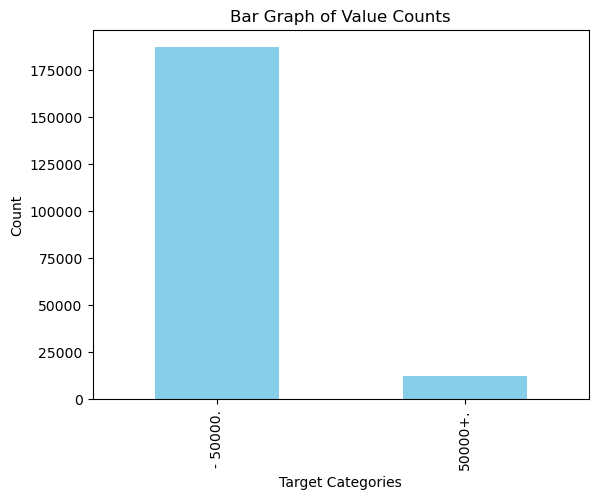

In [14]:
class_distribution = base_training_df['Y'].value_counts()
print("Target variable data distribution - ",class_distribution)
# Plot a bar graph
class_distribution.plot(kind='bar', color='skyblue')
# Customize the plot
plt.title('Bar Graph of Value Counts')
plt.xlabel('Target Categories')
plt.ylabel('Count')
# Show the plot
plt.show()

### Missing Data Detection

#### Training DataSet

In [15]:
training_nan_counts = base_training_df.isna().sum()
# Filter columns with NaN values
training_columns_nan_counts = training_nan_counts[training_nan_counts > 0]
print("---------------------Training Input Features with Missing Data----------------------------------")
print(training_columns_nan_counts)

---------------------Training Input Features with Missing Data----------------------------------
GRINST        708
MIGMTR1     99696
MIGMTR3     99696
MIGMTR4     99696
MIGSUN      99696
PEFNTVTY     6713
PEMNTVTY     6119
PENATVTY     3393
dtype: int64


##### Moving Missing column names into a list

In [16]:
training_missing_index = training_columns_nan_counts.index
training_missing_data_column_list = []
for i in training_missing_index:
    training_missing_data_column_list.append(i)

In [17]:
print("Features with missing data : ", training_missing_data_column_list)

Features with missing data :  ['GRINST', 'MIGMTR1', 'MIGMTR3', 'MIGMTR4', 'MIGSUN', 'PEFNTVTY', 'PEMNTVTY', 'PENATVTY']


##### Percentage of Missing data in Training DataSet

In [18]:
training_missing_data_percentage = (training_columns_nan_counts[training_missing_data_column_list] / base_training_df.shape[0]) * 100
print("----------------Percentage of Missing data in each column------------------")
print(training_missing_data_percentage)

----------------Percentage of Missing data in each column------------------
GRINST       0.354846
MIGMTR1     49.967172
MIGMTR3     49.967172
MIGMTR4     49.967172
MIGSUN      49.967172
PEFNTVTY     3.364524
PEMNTVTY     3.066814
PENATVTY     1.700556
dtype: float64


#### Validation DataSet

In [19]:
validation_nan_counts = validation_df.isna().sum()
# Filter columns with NaN values
validation_columns_nan_counts = validation_nan_counts[validation_nan_counts > 0]
print("---------------------Features with Missing data in Validation dataset----------------------------------")
print(validation_columns_nan_counts)

---------------------Features with Missing data in Validation dataset----------------------------------
GRINST        330
MIGMTR1     49946
MIGMTR3     49946
MIGMTR4     49946
MIGSUN      49946
PEFNTVTY     3429
PEMNTVTY     3072
PENATVTY     1764
dtype: int64


In [20]:
validation_missing_index = validation_columns_nan_counts.index
validation_missing_data_column_list = []
for i in validation_missing_index:
    validation_missing_data_column_list.append(i)
print(validation_missing_data_column_list)

['GRINST', 'MIGMTR1', 'MIGMTR3', 'MIGMTR4', 'MIGSUN', 'PEFNTVTY', 'PEMNTVTY', 'PENATVTY']


In [21]:
validation_missing_data_percentage = (validation_columns_nan_counts[validation_missing_data_column_list] / validation_df.shape[0]) * 100
print("----------------Percentage of Missing data in each column------------------")
print(validation_missing_data_percentage)

----------------Percentage of Missing data in each column------------------
GRINST       0.330787
MIGMTR1     50.065155
MIGMTR3     50.065155
MIGMTR4     50.065155
MIGSUN      50.065155
PEFNTVTY     3.437180
PEMNTVTY     3.079329
PENATVTY     1.768208
dtype: float64


### Missing Data Handling

In [22]:
continuous_features = ['AAGE','AHRSPAY','CAPGAIN','CAPLOSS','DIVVAL','NOEMP','WKSWORK']
all_features = base_training_df.columns
nominal_features = [feature for feature in all_features if feature not in continuous_features]

#### Calculating the Mode of columns with Missing Data

In [23]:
column_mapping = {}

# Map continuous columns to mean values
for column in continuous_features:
    column_mapping[column] = base_training_df[column].median()

# Map nominal columns to mode values
for column in nominal_features:
    column_mapping[column] = base_training_df[column].mode().iloc[0]

# Remove Target variable
del column_mapping['Y']

#### Dumping the missing values for inference pipeline

In [24]:
from joblib import dump
dump(column_mapping, 'missing_values.joblib')

['missing_values.joblib']

#### Loading the missing values for validation dataset

In [25]:
from joblib import load
loaded_column_mapping = load('missing_values.joblib')

#### Filling the missing data for training and validation dataset

In [26]:
for feature, value in loaded_column_mapping.items():
        base_training_df[feature].fillna(value, inplace=True)

In [27]:
for feature, value in loaded_column_mapping.items():
        validation_df[feature].fillna(value, inplace=True)

### Visualization

#### Nominal Features VS Target Variable

In [28]:
for column in nominal_columns_training_df:
    group_counts_by_y = nominal_columns_training_df.groupby([column, 'Y']).size().unstack(fill_value=0)
    print(group_counts_by_y)

Y                               - 50000.  50000+.
ACLSWKR                                          
Federal government                  2328      597
Local government                    6937      847
Never worked                         437        2
Not in universe                    99341      904
Private                            64706     7322
Self-employed-incorporated          2131     1134
Self-employed-not incorporated      7355     1090
State government                    3742      485
Without pay                          164        1
Y                                       - 50000.  50000+.
AHGA                                                     
10th grade                                  7495       62
11th grade                                  6806       70
12th grade no diploma                       2092       34
1st 2nd 3rd or 4th grade                    1786       13
5th or 6th grade                            3255       22
7th and 8th grade                           

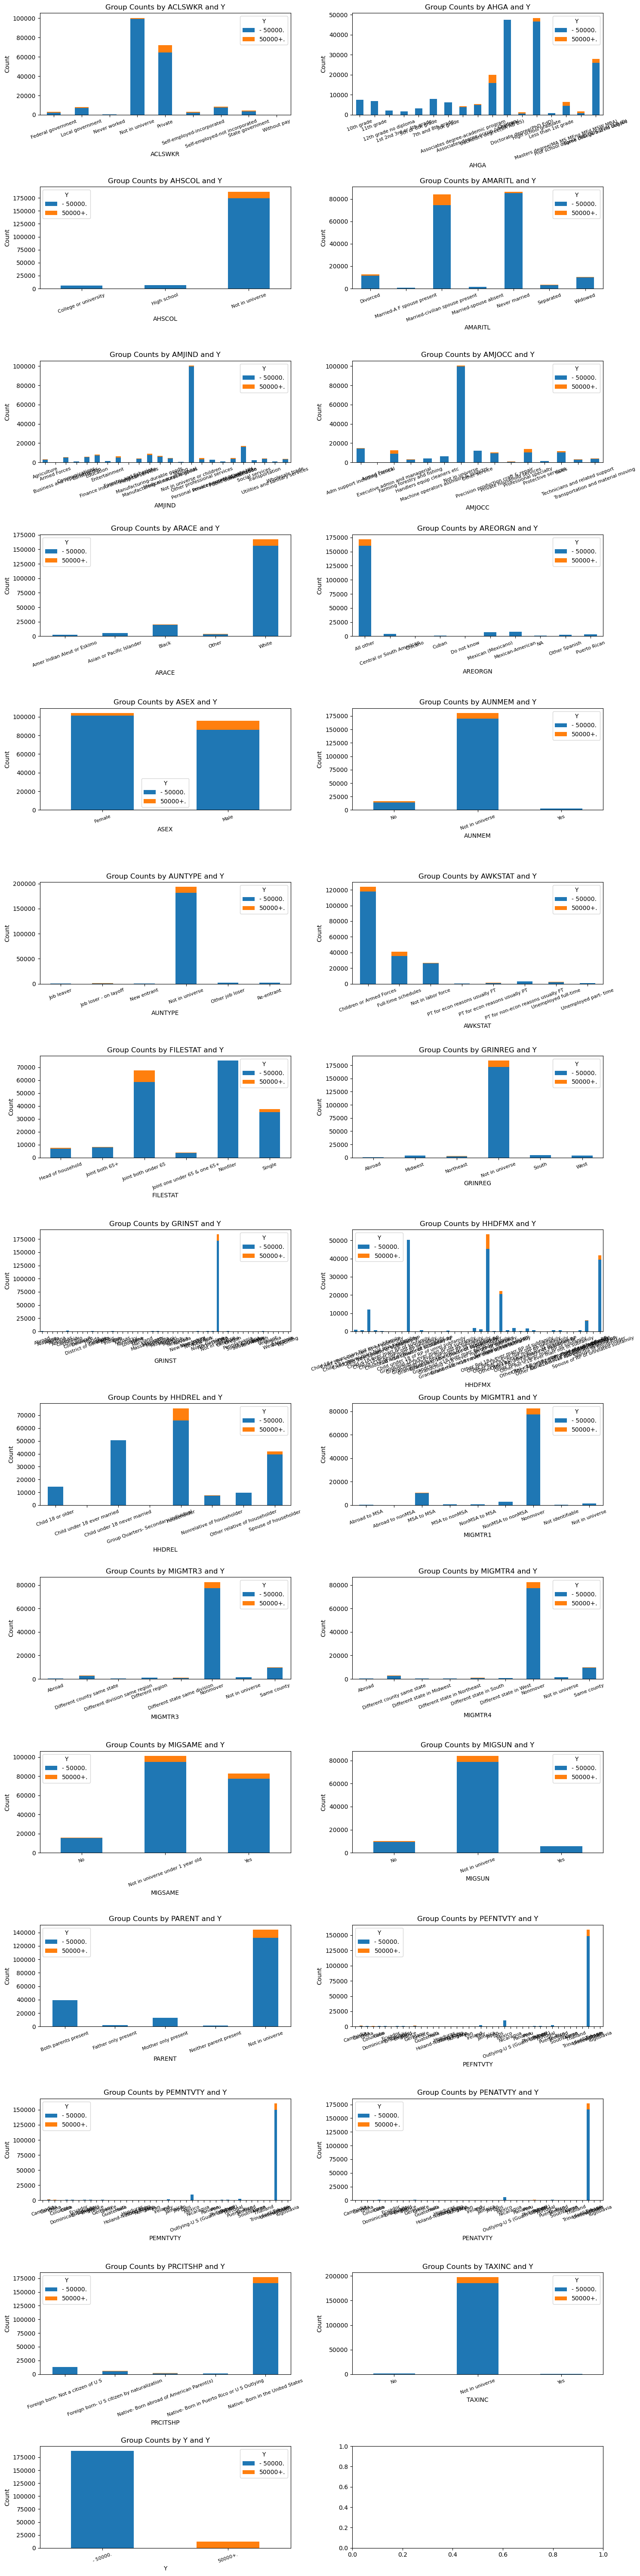

In [29]:
import math
# Determine the number of plots per row
plots_per_row = 2
# Calculate the number of rows required
num_plots = len(nominal_columns_training_df.columns)
num_rows = math.ceil(num_plots / plots_per_row)
# Create subplots
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, 4*num_rows))
axes = axes.flatten()
# Loop through nominal columns
for i, column in enumerate(nominal_columns_training_df.columns):
    # Group data by column and 'Y', and count occurrences
    group_counts_by_y = nominal_columns_training_df.groupby([column, 'Y']).size().unstack(fill_value=0)
    # Plot a bar plot on the corresponding subplot
    group_counts_by_y.plot(kind='bar', stacked=True, title=f'Group Counts by {column} and Y', ax=axes[i])
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=20, labelsize=8)  # Adjust rotation and label size
# Adjust layout
plt.tight_layout()
plt.show()

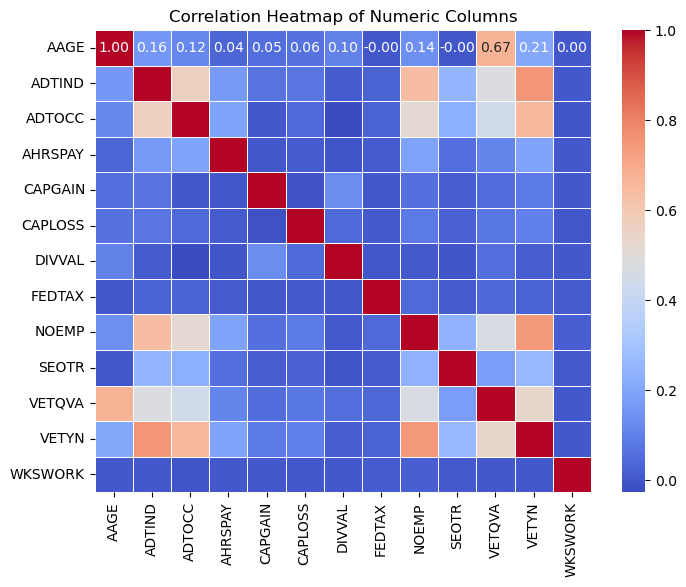

In [30]:
numeric_columns = base_training_df.select_dtypes(include=[np.number])
correlation_matrix = numeric_columns.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Columns')
plt.show()

#### Box Plot
     To find the outlier in continous variables

-------------------Features with outliers -------------------------
ColumnName      Count        Percentage
----------      -----        ----------
AHRSPAY         - 11304      - 5.67%
CAPGAIN         - 7379       - 3.70%
CAPLOSS         - 3906       - 1.96%
DIVVAL          - 21141      - 10.60%
FEDTAX          - 6238       - 3.13%
SEOTR           - 18851      - 9.45%
VETQVA          - 49393      - 24.76%


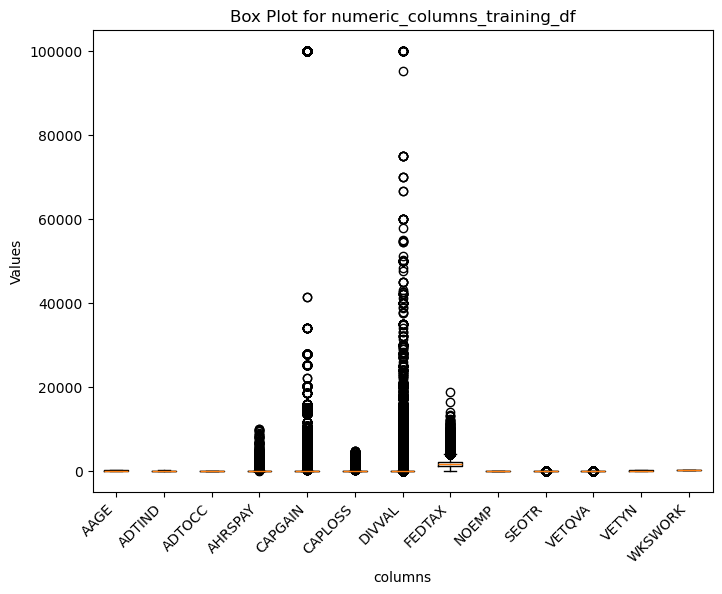

In [31]:
print("-------------------Features with outliers -------------------------")
print(f"{'ColumnName'.ljust(16)}{'Count'.ljust(13)}{'Percentage'.ljust(10)}")
print(f"{'----------'.ljust(16)}{'-----'.ljust(13)}{'----------'.ljust(10)}")
for column in numeric_columns_training_df:
    outliers = []
    Q1 = base_training_df[column].quantile(0.25)
    Q3 = base_training_df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers = base_training_df[(base_training_df[column] < lower_bound) | (base_training_df[column] > upper_bound)]
    if len(outliers):
        print(f"{column.ljust(15)} - {str(len(outliers)).ljust(10)} - {(len(outliers)/base_training_df.shape[0])*100:.2f}%")
plt.figure(figsize=(8, 6))
plt.boxplot(numeric_columns_training_df,labels=numeric_columns_training_df.columns)
plt.title(f'Box Plot for {"numeric_columns_training_df"}')
plt.xlabel('columns')
plt.ylabel('Values')
plt.xticks(rotation=45, ha='right')
plt.show()

## Feature Engineering

### Transformation of nominal data using Encoding

#### Understand the number of unique group in each Nominl feature

In [32]:
unique_counts_training = base_training_df.nunique()
unique_counts_validation = validation_df.nunique()

In [33]:
print(unique_counts_training)

AAGE           91
ACLSWKR         9
ADTIND         52
ADTOCC         47
AHGA           17
AHRSPAY      1240
AHSCOL          3
AMARITL         7
AMJIND         24
AMJOCC         15
ARACE           5
AREORGN        10
ASEX            2
AUNMEM          3
AUNTYPE         6
AWKSTAT         8
CAPGAIN       132
CAPLOSS       113
DIVVAL       1478
FILESTAT        6
GRINREG         6
GRINST         50
HHDFMX         38
HHDREL          8
FEDTAX      99800
MIGMTR1         9
MIGMTR3         8
MIGMTR4         9
MIGSAME         3
MIGSUN          3
NOEMP           7
PARENT          5
PEFNTVTY       42
PEMNTVTY       42
PENATVTY       42
PRCITSHP        5
SEOTR           3
TAXINC          3
VETQVA          3
VETYN          53
WKSWORK         2
Y               2
dtype: int64


In [34]:
print( unique_counts_validation)

AAGE           91
ACLSWKR         9
ADTIND         52
ADTOCC         47
AHGA           17
AHRSPAY       894
AHSCOL          3
AMARITL         7
AMJIND         24
AMJOCC         15
ARACE           5
AREORGN        10
ASEX            2
AUNMEM          3
AUNTYPE         6
AWKSTAT         8
CAPGAIN       123
CAPLOSS       111
DIVVAL       1140
FILESTAT        6
GRINREG         6
GRINST         50
HHDFMX         37
HHDREL          8
FEDTAX      64741
MIGMTR1         9
MIGMTR3         8
MIGMTR4         9
MIGSAME         3
MIGSUN          3
NOEMP           7
PARENT          5
PEFNTVTY       42
PEMNTVTY       42
PENATVTY       42
PRCITSHP        5
SEOTR           3
TAXINC          3
VETQVA          3
VETYN          53
WKSWORK         2
Y               2
dtype: int64


#### Implementing Label Encoding Technique for Nominal Data transformation

In [35]:
label_encoder = LabelEncoder()
encoded_base_training_df = base_training_df.copy()
encoding_mappings = {}
for column in nominal_columns_training_df.columns:
    #print(column)
    encoded_base_training_df[column] = label_encoder.fit_transform(encoded_base_training_df[column])
    # Mapping between original values and encoded labels for each column
    encoding_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    encoding_mappings[column] = encoding_mapping
    encoding_dump_map = encoding_mappings.copy()

#### Dumping the .joblib file for mapping in inference pipeline

In [36]:
del encoding_dump_map['Y']

In [37]:
from joblib import dump
dump(encoding_dump_map, 'label_encoder.joblib')

['label_encoder.joblib']

#### Loading the encoding pickle file and use for encoding

In [38]:
#label_encoder_mapping = load('label_encoder.joblib')

#### Using the label encoded pickle file to transform the validation dataset

In [39]:
#Creating a copy of validation_df file
encoded_validation_df = validation_df.copy()

In [40]:
for column, encoding_mapping in encoding_mappings.items():
    encoded_validation_df[column] = encoded_validation_df[column].map(encoding_mapping).fillna(-1).astype(int)

In [41]:
encoded_base_training_df.head(2)

,AAGE,ACLSWKR,ADTIND,ADTOCC,AHGA,AHRSPAY,AHSCOL,AMARITL,AMJIND,AMJOCC,ARACE,AREORGN,ASEX,AUNMEM,AUNTYPE,AWKSTAT,CAPGAIN,CAPLOSS,DIVVAL,FILESTAT,GRINREG,GRINST,HHDFMX,HHDREL,FEDTAX,MIGMTR1,MIGMTR3,MIGMTR4,MIGSAME,MIGSUN,NOEMP,PARENT,PEFNTVTY,PEMNTVTY,PENATVTY,PRCITSHP,SEOTR,TAXINC,VETQVA,VETYN,WKSWORK,Y
0,73,3,0,0,12,0,2,6,14,6,4,0,0,1,3,2,0,0,0,4,3,35,24,6,1700.09,6,5,6,1,1,0,4,39,39,39,4,0,1,2,0,95,0
1,58,6,4,34,16,0,2,0,4,8,4,0,1,1,3,0,0,0,0,0,4,4,20,4,1053.55,2,7,8,0,2,1,4,39,39,39,4,0,1,2,52,94,0


In [42]:
encoded_validation_df.head(2)

,AAGE,ACLSWKR,ADTIND,ADTOCC,AHGA,AHRSPAY,AHSCOL,AMARITL,AMJIND,AMJOCC,ARACE,AREORGN,ASEX,AUNMEM,AUNTYPE,AWKSTAT,CAPGAIN,CAPLOSS,DIVVAL,FILESTAT,GRINREG,GRINST,HHDFMX,HHDREL,FEDTAX,MIGMTR1,MIGMTR3,MIGMTR4,MIGSAME,MIGSUN,NOEMP,PARENT,PEFNTVTY,PEMNTVTY,PENATVTY,PRCITSHP,SEOTR,TAXINC,VETQVA,VETYN,WKSWORK,Y
0,38,4,6,36,3,0,2,2,10,5,4,5,0,1,3,1,0,0,0,3,3,35,37,7,1032.38,6,5,6,1,1,4,4,25,25,25,0,0,1,2,12,95,0
1,44,6,37,12,8,0,2,2,2,10,4,0,0,1,3,4,0,0,2500,2,3,35,37,7,1462.33,6,5,6,1,1,1,4,39,39,39,4,0,1,2,26,95,0


### Splitting X_train and Y_train

In [43]:
def xy_split():
    Y_train = encoded_base_training_df['Y']
    X_train = encoded_base_training_df.drop('Y', axis=1)
    Y_test = encoded_validation_df['Y']
    X_test = encoded_validation_df.drop('Y', axis=1)
    return X_train, Y_train, X_test, Y_test

In [44]:
X_train, Y_train, X_test, Y_test = xy_split()

### Feature Importance for training data

#### Random Forest (RF) Feature Importance

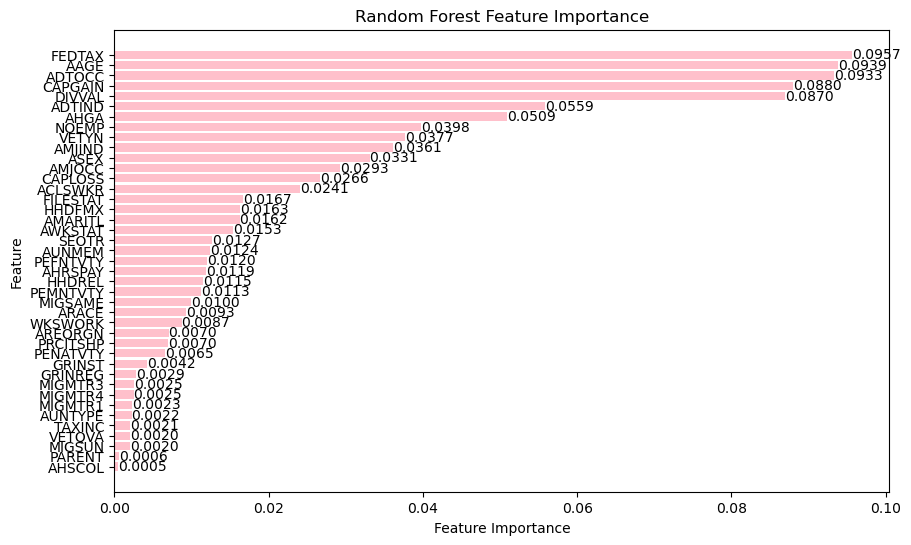

In [45]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the data
clf.fit(X_train, Y_train)

# Get feature importances
rf_feature_importances = clf.feature_importances_

# Create a DataFrame to display feature importances
rf_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf_feature_importances})

# Sort the DataFrame by importance in descending order
rf_importance_df = rf_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
bars = plt.barh(rf_importance_df['Feature'], rf_importance_df['Importance'],color='pink')
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, f'{width:.4f}', ha='left', va='center')
# Plot feature importances

plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()  # Invert the y-axis to display most important features at the top
plt.show()

In [46]:
list_rf_top20_features = rf_importance_df["Feature"].head(20).tolist()
print(list_rf_top20_features)

['FEDTAX', 'AAGE', 'ADTOCC', 'CAPGAIN', 'DIVVAL', 'ADTIND', 'AHGA', 'NOEMP', 'VETYN', 'AMJIND', 'ASEX', 'AMJOCC', 'CAPLOSS', 'ACLSWKR', 'FILESTAT', 'HHDFMX', 'AMARITL', 'AWKSTAT', 'SEOTR', 'AUNMEM']


#### Gradient Boosting(GB) Feature Importance

In [47]:
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold  # Changed to RepeatedStratifiedKFold for classification
from sklearn.ensemble import GradientBoostingClassifier  # Changed to GradientBoostingClassifier for classification

# Assuming X_train and Y_train are your features and target for classification

# define dataset
gb_model = GradientBoostingClassifier(random_state=0, learning_rate=0.1, n_estimators=150, max_depth=3)

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2, random_state=1)  # Changed to RepeatedStratifiedKFold for classification

# evaluate the model
gb_metrics_scores = cross_val_score(gb_model, X_train, Y_train, scoring='roc_auc', cv=cv, n_jobs=-1)

# report performance
roc_auc = mean(gb_metrics_scores)
print('roc_auc:', roc_auc)

roc_auc: 0.9479305441759209


In [48]:
gb_model.fit(X_train,Y_train)

GradientBoostingClassifier(n_estimators=150, random_state=0)

In [49]:
Y_predicted = gb_model.predict(X_test)
test_gb_model_r2 = gb_model.score(X_test, Y_test)
print( "R2 of the Test out of sample data :", test_gb_model_r2)

R2 of the Test out of sample data : 0.9552735510515026


In [50]:
gb_importance = gb_model.feature_importances_

In [51]:
def plot_feature_importance(importance,names,model_type):
  #Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

  #Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

  #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

  #Define size of bar plot
  plt.figure(figsize=(10,5))
  #Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
  for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, f'{width:.4f}', ha='left', va='center')
  #Add chart labels
  plt.title(model_type + 'FEATURE IMPORTANCE')
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')

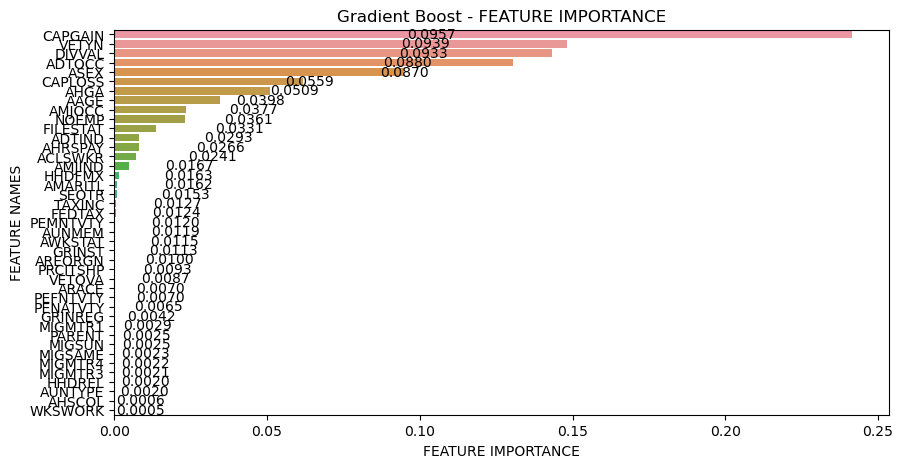

In [52]:
plot_feature_importance(gb_model.feature_importances_,X_train.columns,'Gradient Boost - ')

In [53]:
feature_importances = gb_model.feature_importances_
# Create a DataFrame to associate feature names with their importances
gb_feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
# Sort the DataFrame by importance in descending order
sorted_gb_feature_importance = gb_feature_importance_df.sort_values(by='Importance', ascending=False)
# Get the top 20 features
gb_top_20_features = sorted_gb_feature_importance["Feature"].head(20)
list_gb_top_20_features = gb_top_20_features.tolist()

In [54]:
print(list_gb_top_20_features)

['CAPGAIN', 'VETYN', 'DIVVAL', 'ADTOCC', 'ASEX', 'CAPLOSS', 'AHGA', 'AAGE', 'AMJOCC', 'NOEMP', 'FILESTAT', 'ADTIND', 'AHRSPAY', 'ACLSWKR', 'AMJIND', 'HHDFMX', 'AMARITL', 'SEOTR', 'TAXINC', 'FEDTAX']


#### Recurrsive Feature Elimation

In [55]:
from sklearn import model_selection
from sklearn.feature_selection import RFE

rfe = RFE(gb_model)
fit = rfe.fit(X_train, Y_train)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))
rfe_feature_dump = X_train.columns[(fit.get_support())]
print("-------------------Recursive Feature Elimination Results---------------------")
print(rfe_feature_dump)

Num Features: 20
Selected Features: [ True  True  True  True  True  True False  True  True  True False False
  True False False False  True  True  True  True False False  True False
  True False False False False False  True False False False False False
  True  True False  True False]
Feature Ranking: [ 1  1  1  1  1  1 12  1  1  1  7  6  1  2 19  5  1  1  1  1 11  3  1 16
  1 13 18 20 14 15  1 21  9  4 10  8  1  1 17  1 22]
-------------------Recursive Feature Elimination Results---------------------
Index(['AAGE', 'ACLSWKR', 'ADTIND', 'ADTOCC', 'AHGA', 'AHRSPAY', 'AMARITL',
       'AMJIND', 'AMJOCC', 'ASEX', 'CAPGAIN', 'CAPLOSS', 'DIVVAL', 'FILESTAT',
       'HHDFMX', 'FEDTAX', 'NOEMP', 'SEOTR', 'TAXINC', 'VETYN'],
      dtype='object')


In [56]:
rfe_features = rfe_feature_dump.to_numpy().tolist()

#### Feature Selection Based on the RF, GB and RFE

In [ ]:
###### Remove in final

rfe_features = ['ACLSWKR', 'AHGA', 'AMARITL', 'AMJIND',
       'AMJOCC', 'ASEX', 'FILESTAT', 'HHDFMX',
       'TAXINC', 'AAGE', 'ADTIND', 'ADTOCC',
       'AHRSPAY', 'CAPGAIN', 'CAPLOSS',
       'DIVVAL', 'FEDTAX', 'NOEMP', 'SEOTR',
       'VETYN']

In [57]:
common_selected_features = set(rfe_features) & set(list_gb_top_20_features) & set(list_rf_top20_features)
# Get the set of all unique items across the lists
all_unique_selected_features = set(rfe_features) | set(list_gb_top_20_features) | set(list_rf_top20_features)

In [58]:
print(common_selected_features)

{'HHDFMX', 'FEDTAX', 'AHGA', 'FILESTAT', 'AMJIND', 'DIVVAL', 'CAPLOSS', 'CAPGAIN', 'ADTIND', 'ACLSWKR', 'AAGE', 'AMARITL', 'ADTOCC', 'VETYN', 'ASEX', 'AMJOCC', 'SEOTR', 'NOEMP'}


## Validation to check if the data in training and validation are from same distribution

The validation is done using Random forest method by adding an additional target variable to identify if the record is from Training or test and then using it as a target variable and run a random forrect algorithm to check how effectively the model is able to segregate the training and testing record

##### Preparing data for validation of data distribution

In [59]:
X_train_val = X_train.copy()
X_test_val = X_test.copy()
X_train_val["dataset_type"] = 0
X_test_val["dataset_type"] = 1
X_train_test = pd.concat([X_train_val, X_test_val], ignore_index=True)
Y_train_test = X_train_test['dataset_type']
X_train_test = X_train_test.drop('dataset_type', axis=1)

In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.metrics import roc_auc_score

# Split the dataset into training and testing sets
val_X_train, val_X_test, val_y_train, val_y_test = train_test_split(X_train_test, Y_train_test, test_size=0.2, random_state=42,shuffle=True, stratify=None)

# Define the Random Forest classifier
rf_classifier = RandomForestClassifier()

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(10, 200),
    'max_features': [None,0.25, 0.5, 0.75, 1],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'bootstrap': [True, False]
}

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(rf_classifier, param_distributions=param_dist, n_iter=2, cv=5, scoring='roc_auc', random_state=42, n_jobs=-1)
random_search.fit(val_X_train, val_y_train)

# Get the best model
best_rf_model = random_search.best_estimator_

# Make predictions on the test set
predictions = best_rf_model.predict(val_X_test)

# Evaluate the model
#accuracy = np.mean(predictions == val_y_test)
roc_auc = roc_auc_score(val_y_test, predictions)
print(f"Accuracy: {roc_auc:.4f}")

# Display the best hyperparameters
print("Best Hyperparameters:")
print(random_search.best_params_)

Accuracy: 0.5000
Best Hyperparameters:
{'bootstrap': True, 'max_depth': 40, 'max_features': 0.25, 'min_samples_leaf': 19, 'min_samples_split': 12, 'n_estimators': 97}


#### Conclusion on distribution validation: 
##### Since the ROC_AUC is less than .8 we can consider that the features are of same distribution as the RF model is not able to segreggate the training and testing data properly

In [61]:
best_rf_model_feature = best_rf_model.feature_importances_

In [62]:
best_rf_model_feature = best_rf_model.feature_importances_
# Create a DataFrame to associate feature names with their importances
best_rf_model_importance_df = pd.DataFrame({'Feature': val_X_train.columns, 'Importance': best_rf_model_feature})
# Sort the DataFrame by importance in descending order
sorted_best_rf_model_feature_importance = best_rf_model_importance_df.sort_values(by='Importance', ascending=False)
# Get the top 20 features
best_rf_model_top_5_features = sorted_best_rf_model_feature_importance["Feature"].head(5)
print("Top 5 feature which has deviation in distribution between test and train data are as below:")
print(best_rf_model_top_5_features.tolist())

Top 5 feature which has deviation in distribution between test and train data are as below:
['FEDTAX', 'AAGE', 'AHGA', 'ADTOCC', 'ADTIND']


In [63]:
list_gb_top_20_features

['CAPGAIN',
 'VETYN',
 'DIVVAL',
 'ADTOCC',
 'ASEX',
 'CAPLOSS',
 'AHGA',
 'AAGE',
 'AMJOCC',
 'NOEMP',
 'FILESTAT',
 'ADTIND',
 'AHRSPAY',
 'ACLSWKR',
 'AMJIND',
 'HHDFMX',
 'AMARITL',
 'SEOTR',
 'TAXINC',
 'FEDTAX']

## Model Training

#### Multiple models are trained using RandomSearchCV hyperparameter training option for 2 different set of features selected by Feature selection Method
##### 1. Features that are common on all 3 feature selection process
##### 2. Unique Features present within the 3 feature selection process

In [64]:
X_train, Y_train, X_test, Y_test = xy_split()

In [65]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from scipy.stats import randint, uniform
from sklearn import tree
import pandas as pd


# ...

# Add AdaBoostClassifier to the classifiers dictionary
classifiers = {
    'Random Forest': (RandomForestClassifier(), {'n_estimators': randint(10, 100), 'max_depth': randint(5, 20)}),
    'Gradient Boosting': (GradientBoostingClassifier(), {'n_estimators': randint(10, 200), 'max_depth': randint(3, 20)}),
    'k-Nearest Neighbors': (KNeighborsClassifier(), {'n_neighbors': randint(1, 20), 'weights': ['uniform', 'distance']}),
    'Logistic Regression': (LogisticRegression(solver='liblinear', max_iter=1000), {'C': uniform(0.1, 10), 'penalty': ['l1', 'l2']}),
    'AdaBoost': (AdaBoostClassifier(), {'n_estimators': randint(10, 100), 'learning_rate': uniform(0.01, 1.0)})
}

# ...

# Loop through classifiers
for name, (clf, param_dist) in classifiers.items():
    # Perform RandomizedSearchCV
    random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=10, cv=3, random_state=42, n_jobs=-1)
    random_search.fit(X_train, Y_train)

    # Get the best model
    best_model = random_search.best_estimator_

    # Make predictions on the test set
    predictions = best_model.predict(X_test)
    
    # Evaluate the model
    roc_auc = roc_auc_score(Y_test, predictions)
    print(f"{name}: ROC_AUC - {roc_auc:.4f}, Best Parameters: {random_search.best_params_}")


Random Forest: ROC_AUC - 0.6784, Best Parameters: {'max_depth': 17, 'n_estimators': 30}
Gradient Boosting: ROC_AUC - 0.7327, Best Parameters: {'max_depth': 5, 'n_estimators': 159}
k-Nearest Neighbors: ROC_AUC - 0.6055, Best Parameters: {'n_neighbors': 19, 'weights': 'uniform'}
Logistic Regression: ROC_AUC - 0.6309, Best Parameters: {'C': 6.086584841970366, 'penalty': 'l1'}
AdaBoost: ROC_AUC - 0.6767, Best Parameters: {'learning_rate': 0.606850157946487, 'n_estimators': 92}


In [66]:
X_train, Y_train, X_test, Y_test = xy_split()

In [68]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from scipy.stats import randint, uniform
from sklearn import tree
import pandas as pd

# Assuming X_train, X_test, Y_train, and Y_test are defined

X1_train = X_train[list(common_selected_features)]
X2_train = X_train[list(all_unique_selected_features)]
X1_test = X_test[list(common_selected_features)]
X2_test = X_test[list(all_unique_selected_features)]

# Define the classifiers and their respective hyperparameter grids
classifiers = {
    'Random Forest': (RandomForestClassifier(), {'n_estimators': randint(10, 100), 'max_depth': randint(5, 20)}),
    'Gradient Boosting': (GradientBoostingClassifier(), {'n_estimators': randint(10, 200), 'max_depth': randint(3, 20)}),
    'k-Nearest Neighbors': (KNeighborsClassifier(), {'n_neighbors': randint(1, 20), 'weights': ['uniform', 'distance']}),
    'Logistic Regression': (LogisticRegression(solver='liblinear', max_iter=1000), {'C': uniform(0.1, 10), 'penalty': ['l1', 'l2']}),
    'AdaBoost': (AdaBoostClassifier(), {'n_estimators': randint(10, 100), 'learning_rate': uniform(0.01, 1.0)})
}

# Loop through feature sets
for feature_set, X_train, X_test in zip(['Feature Set 1', 'Feature Set 2'], [X1_train, X2_train], [X1_test, X2_test]):

    print(f"\n--- {feature_set} ---")

    # Loop through classifiers
    for name, (clf, param_dist) in classifiers.items():
        # Perform RandomizedSearchCV
        random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=5, cv=3, random_state=42, n_jobs=-1)
        random_search.fit(X_train, Y_train)

        # Get the best model
        best_model = random_search.best_estimator_

        # Make predictions on the test set
        predictions = best_model.predict(X_test)
        #print(predictions)
        #print(Y_test)
        # Evaluate the model
        roc_auc = roc_auc_score(Y_test, predictions)
        print(f"{name}: ROC_AUC - {roc_auc:.4f}, Best Parameters: {random_search.best_params_}")


--- Feature Set 1 ---
Random Forest: ROC_AUC - 0.6926, Best Parameters: {'max_depth': 17, 'n_estimators': 24}
Gradient Boosting: ROC_AUC - 0.7351, Best Parameters: {'max_depth': 9, 'n_estimators': 131}
k-Nearest Neighbors: ROC_AUC - 0.6042, Best Parameters: {'n_neighbors': 19, 'weights': 'uniform'}
Logistic Regression: ROC_AUC - 0.6301, Best Parameters: {'C': 0.6808361216819946, 'penalty': 'l2'}
AdaBoost: ROC_AUC - 0.6728, Best Parameters: {'learning_rate': 0.606850157946487, 'n_estimators': 92}

--- Feature Set 2 ---
Random Forest: ROC_AUC - 0.6878, Best Parameters: {'max_depth': 17, 'n_estimators': 24}
Gradient Boosting: ROC_AUC - 0.7383, Best Parameters: {'max_depth': 9, 'n_estimators': 131}
k-Nearest Neighbors: ROC_AUC - 0.6073, Best Parameters: {'n_neighbors': 19, 'weights': 'uniform'}
Logistic Regression: ROC_AUC - 0.6283, Best Parameters: {'C': 0.6808361216819946, 'penalty': 'l2'}
AdaBoost: ROC_AUC - 0.6730, Best Parameters: {'learning_rate': 0.606850157946487, 'n_estimators': 

#### Moving Feature set details to inference pipeline
##### 1. Based on above results Gradient Boosting is the best performing model
##### 2. Even thought Feature set 2 is showing better result, the amount the increase in performance is not significant hence moving feature set 1 as it has lesser number of independent variables

In [80]:
import joblib
with open('feature_list.joblib', 'wb') as feature:  
   joblib.dump(list(common_selected_features), feature)

In [85]:
X1_train = X_train[list(common_selected_features)]
X1_test = X_test[list(common_selected_features)]

In [ ]:
print(common_X_train.columns)

In [82]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
# Assuming X_train, X_test, y_train, y_test are defined

# Create a GradientBoostingClassifier instance
gb_classifier = GradientBoostingClassifier(n_estimators=131, learning_rate=0.1, max_depth=9, random_state=42)

# Train the model
gb_classifier.fit(X1_train, Y_train)

# Make predictions on the training set
train_predictions = gb_classifier.predict(X1_train)

# Evaluate the model on the training set
roc_auc_train = roc_auc_score(Y_train, train_predictions)
print(f"Training ROC_AUC: {roc_auc_train:.4f}")
train_accuracy = accuracy_score(Y_train, train_predictions)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Make predictions on the test set
test_predictions = gb_classifier.predict(X1_test)

# Evaluate the model on the test set
roc_auc_test = roc_auc_score(Y_test, test_predictions)
print(f"Testing ROC_AUC: {roc_auc_test:.4f}")
test_accuracy = accuracy_score(Y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.9739
Test Accuracy: 0.9574


In [86]:
import joblib
with open('model.joblib', 'wb') as mod:  
   joblib.dump(gb_classifier, mod)

In [83]:
roc_auc_test, roc_auc_train

(0.7349861815563311, 0.8199940818836617)

### JSON creation code for a testing using validation dataset

In [ ]:
record_number = 0

In [ ]:
import json

columns = encoded_validation_df.columns.tolist()
columns.remove('Y')
first_row_values = validation_df.iloc[record_number]

# Convert int64 values to native Python types
converted_values = [item if not isinstance(item, np.int64) else item.item() for item in first_row_values]

# Create a dictionary with column names and values
data_dict = dict(zip(columns, converted_values))

# Specify the file path where you want to save the JSON data
json_file_path = 'test_data.json'

# Save the dictionary to a JSON file
with open(json_file_path, 'w') as json_file:
    json.dump(data_dict, json_file, indent=2)

print(f"JSON data saved to {json_file_path}")
